For one of our models, we have decided to use k-Nearest Neighbours. While kNN has some limitations, particularly with computational efficiency and sensitivity to irrelevant features, kNN was selected for its interpretability and ease of implementation. Its non-parametric nature means that it makes no assumptions about the underlying distribution of the data, a useful characteristic in situations like ours where the dataset is imbalanced.

In [41]:
import math
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [26]:
# Load the training and testing split from the pickle file
with open('train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

# Load the different splits
with open('train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

We test on a variety of data splits to enhance the reliability of our model evaluation. It helps ensure that our model is not just fitting the data it has seen but is capable of making accurate predictions on new, unseen data, thus increasing its practical value.

In [27]:
# Define the Balanced MCC Macro Average function
def balanced_MCC_macro_avg(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    classes = C.shape[0]
    bal_MCC_each_class = []
    for i in range(classes):
        TP = C[i][i]
        FN = 0
        FP = 0
        TN = 0
        for j in range(classes):
            if j != i:
                FN += C[i][j]
                FP += C[j][i]
                for k in range(classes):
                    if k != i:
                        TN += C[j][k]
        sens = TP / (TP + FN) if (TP + FN) != 0 else 0
        spec = TN / (TN + FP) if (TN + FP) != 0 else 0
        x = (sens + spec - 1) / (math.sqrt(1 - (sens - spec)**2)) if (1 - (sens - spec)**2) != 0 else 0
        bal_MCC_each_class.append(x)
    return np.mean(bal_MCC_each_class)

Balanced MCC provides an additional robustness check, as it averages balanced metrics across classes.

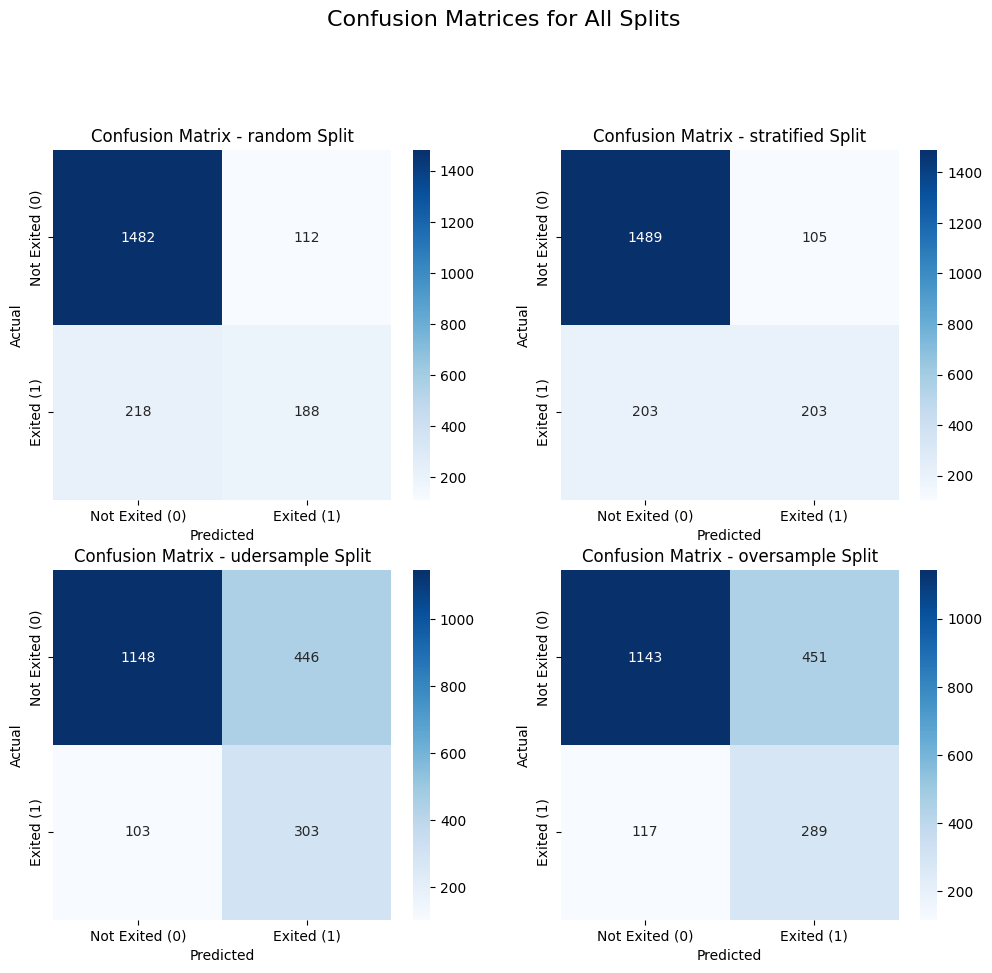

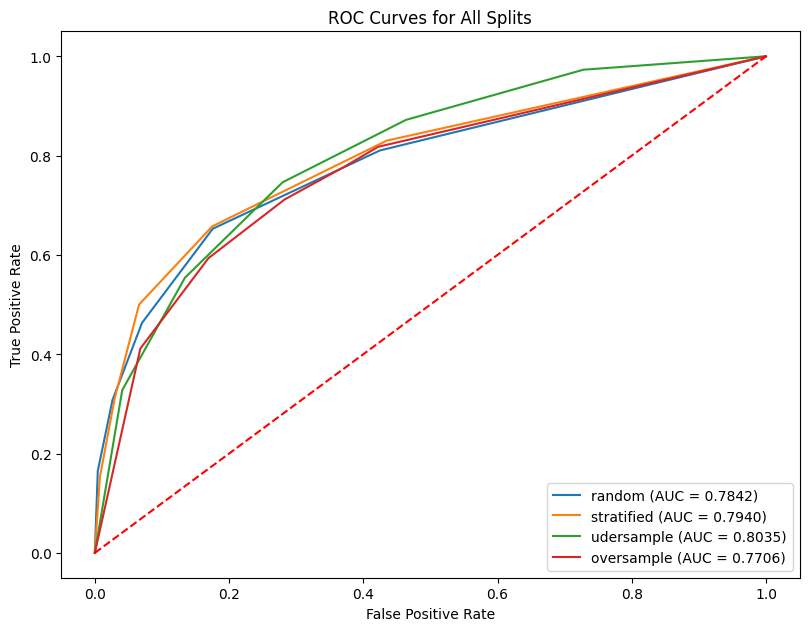

            precision    recall  f1_score   roc_auc  balanced_mcc
random       0.626667  0.463054  0.532578  0.784203      0.444120
stratified   0.659091  0.500000  0.568627  0.793991      0.481909
udersample   0.404539  0.746305  0.524675  0.803465      0.466665
oversample   0.390541  0.711823  0.504363  0.770639      0.428893


In [39]:
# Reinitialize figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8,6))

# Reinitialize dictionary to store performance metrics for each split
performance_metrics = {}

# Iterate over each split in split_data and process them
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Train KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Calculate Balanced MCC Macro Average
    balanced_mcc = balanced_MCC_macro_avg(y_test_raw, y_test_pred)
    
    # Store performance metrics
    performance_metrics[split] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'roc_auc': roc_auc,
        'balanced_mcc': balanced_mcc  # Add Balanced MCC here
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split, including Balanced MCC
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)

We apply StandardScaler to normalize the features, which is necessary for distance-based models like kNN.

Random and Stratified Splits: These splits perform well on the majority class but struggle with the minority class, leading to high false negatives.

Undersample and Oversample Splits:: Both undersampling and oversampling attempt to address class imbalance by improving the model's ability to detect churned customers (minority class) but do so at the cost of increased false positives, which is a typical trade-off in imbalanced datasets.

The overall results from the performance metrics suggest that balancing techniques (either undersampling or oversampling) can help the classifier better detect churned customers but must be applied with care to avoid a significant degradation in the performance for non-churned customers. Further fine-tuning, such as hyperparameter tuning will be used to try and improve performance

Optimal value of k for random split: 3
Optimal value of k for stratified split: 7
Optimal value of k for udersample split: 17
Optimal value of k for oversample split: 1


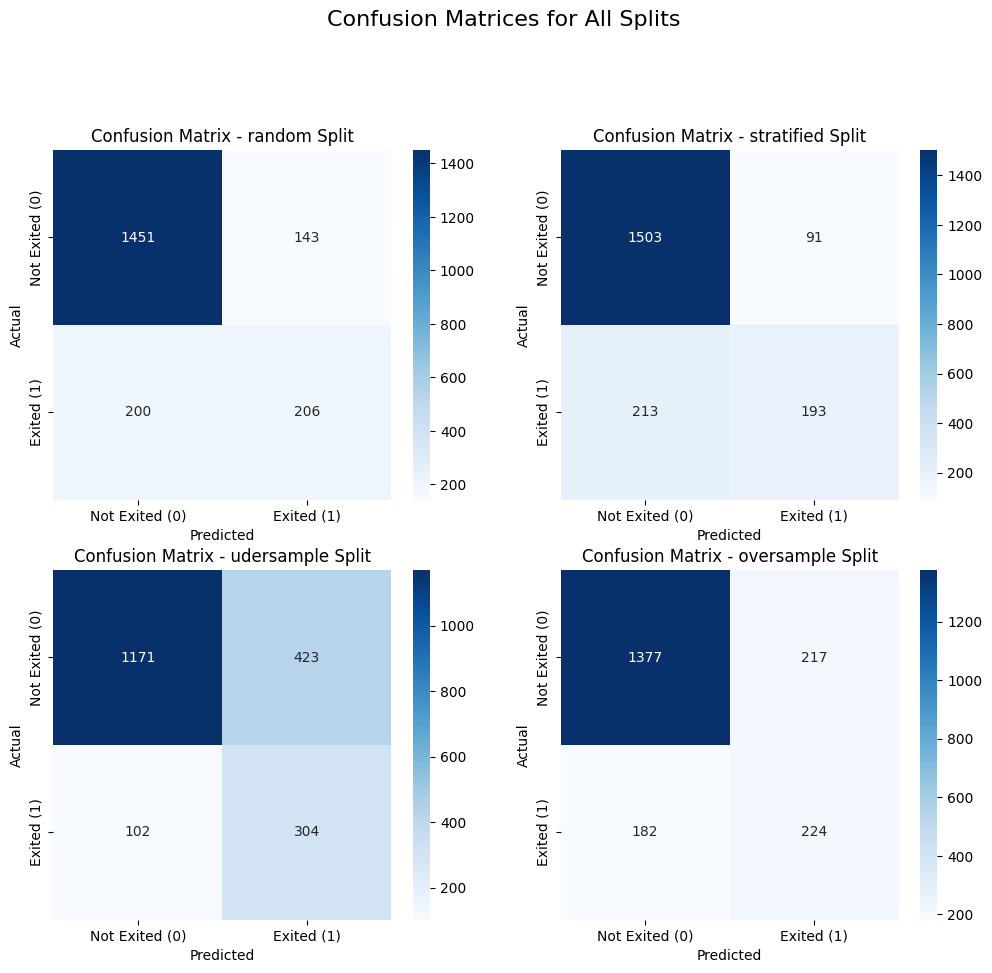

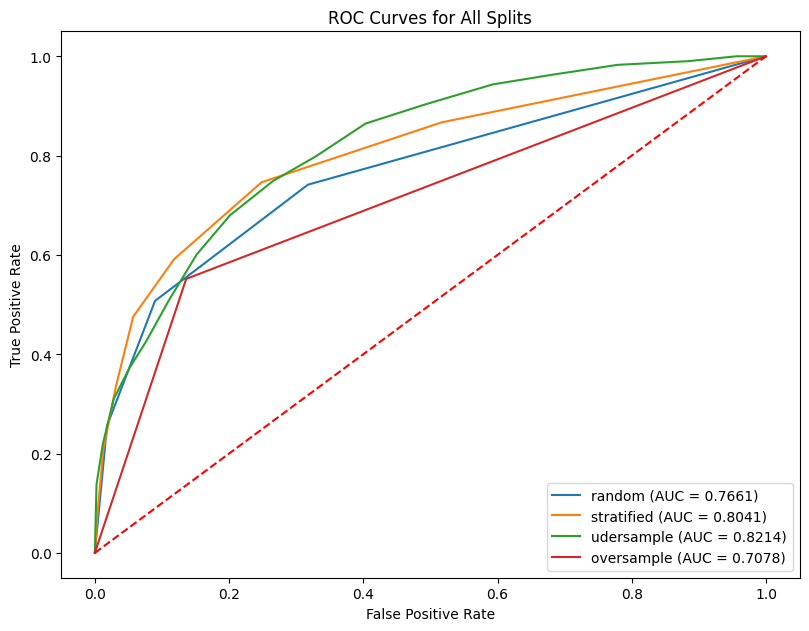

            best_k  precision    recall  f1_score   roc_auc  balanced_mcc
random           3   0.590258  0.507389  0.545695  0.766122      0.456357
stratified       7   0.679577  0.475369  0.559420  0.804144      0.473183
udersample      17   0.418157  0.748768  0.536628  0.821397      0.483447
oversample       1   0.507937  0.551724  0.528926  0.707794      0.437445


In [42]:
# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Set up a range of k values to search
param_grid = {'n_neighbors': list(range(1, 19))}  # Test k from 1 to 18

# Initialize a new figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Initialize a new figure for ROC curves
plt.figure(figsize=(8, 6))

# Dictionary to store performance metrics for each split
performance_metrics = {}

# Loop over each split
for idx, split in enumerate(split_data.keys()):
    # Unpack the current split
    X_train_split, X_val_split, y_train_split, y_val_split = split_data[split]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val_split)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Initialize kNN model and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)
    
    # Fit the model using cross-validation to find the best k
    grid_search.fit(X_train_scaled, y_train_split)
    
    # Get the best k for this split
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Optimal value of k for {split} split: {best_k}")
    
    # Use the best k to train the final model
    knn_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_best.fit(X_train_scaled, y_train_split)
    
    # Predict on validation set
    y_val_pred = knn_best.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Predict on test set
    y_test_pred = knn_best.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)
    
    # Get classification report
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Extract performance metrics for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score_val = test_report['1']['f1-score']
    
    # ROC curve
    y_test_pred_prob = knn_best.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
    
    # Calculate Balanced MCC
    balanced_mcc = balanced_MCC_macro_avg(y_test_raw, y_test_pred)
    
    # Store performance metrics for this split
    performance_metrics[split] = {
        'best_k': best_k,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score_val,
        'roc_auc': roc_auc,
        'balanced_mcc': balanced_mcc  # Store the Balanced MCC
    }

# Finalize confusion matrix plot
plt.tight_layout()
fig.suptitle('Confusion Matrices for All Splits', y=1.02, fontsize=16)

# Finalize ROC curves plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')
plt.show()

# Output the performance metrics for each split, including Balanced MCC
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(performance_df)

Parameter Grid for kNN: A range of potential values for the number of neighbors k (from 1 to 18) is defined. Grid Search Cross-Validation (GridSearchCV) tests each value of k on five folds of the data, aiming to maximize the F1-score for each split. For each split, we use GridSearchCV to find the best value for k. This ensures the kNN model is optimally tuned to detect churned customers.

The F1-score (harmonic mean of precision and recall) is chosen as the primary metric for hyperparameter tuning. F1-Score is chosen as it is a popular, standard metric that balances both false positives and false negatives, which is important when dealing with imbalanced classes.

